In [10]:
import time
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import special_ortho_group, ortho_group
from scipy._lib._util import check_random_state

In [19]:
n_dims = 10
n_repeat = 200
size = 1
dims = np.unique(np.logspace(np.log10(2), np.log10(200), 20, dtype=int))
print('dims: ', dims)

dims:  [  2   3   4   5   6   8  10  13  17  22  28  36  46  59  75  96 123 156
 200]


# SO(N) group

In [20]:
def so_rvs2(dim, size=1, random_state=None):
    """
    Draw random samples from SO(N).
    Parameters
    ----------
    dim : integer
        Dimension of rotation space (N).
    size : integer, optional
        Number of samples to draw (default 1).
    Returns
    -------
    rvs : ndarray or scalar
        Random size N-dimensional matrices, dimension (size, dim, dim)
    """
    random_state = check_random_state(random_state)

    size = int(size)
    if size > 1:
        return np.array([so_rvs2(dim, size=1, random_state=random_state)
                         for i in range(size)])

    H = np.eye(dim)
    D = np.empty((dim,))
    for n in range(dim-1):
        x = random_state.normal(size=(dim-n,))
        norm2 = np.dot(x, x)
        x0 = x[0].item()
        D[n] = np.sign(x[0]) if x[0] != 0 else 1
        x[0] += D[n]*np.sqrt(norm2)
        x /= np.sqrt((norm2 - x0**2 + x[0]**2) / 2.)
        # Householder transformation
        Hx = (np.eye(dim-n) - np.outer(x, x))
        mat = np.eye(dim)
        mat[n:, n:] = Hx
        H = np.dot(H, mat)
    D[-1] = (-1)**(dim-1)*D[:-1].prod()
    # Equivalent to np.dot(np.diag(D), H) but faster, apparently
    H = (D*H.T).T
    return H

In [21]:
ts_so = np.zeros((2, dims.size, n_repeat))
for ii, dim in enumerate(dims):
    for jj in range(n_repeat):
        rng = np.random.RandomState(0)
        start = time.time()
        r0 = special_ortho_group.rvs(dim, random_state=rng, size=size)
        ts_so[0, ii, jj] = time.time() - start
        rng = np.random.RandomState(0)
        start = time.time()
        r1 = so_rvs2(dim, random_state=rng, size=size)
        ts_so[1, ii, jj] = time.time() - start
        assert np.allclose(r0, r1)

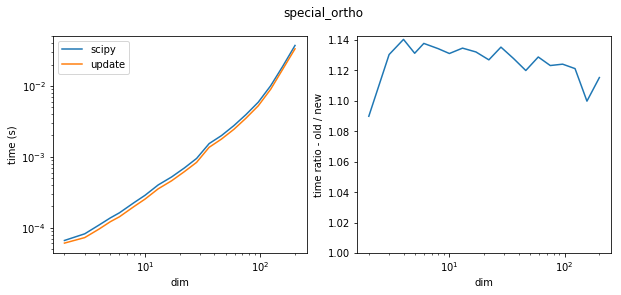

In [28]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
f.suptitle('special_ortho')

ax0.loglog(dims, ts_so[0].mean(axis=-1), label='scipy')
ax0.loglog(dims, ts_so[1].mean(axis=-1), label='update')
ax0.set_xlabel('dim')
ax0.set_ylabel('time (s)')
ax0.legend(loc='best')

ax1.semilogx(dims, ts_so[0].mean(axis=-1) / ts_so[1].mean(axis=-1))
ax1.set_xlabel('dim')
ax1.set_ylabel('time ratio - old / new')
ax1.set_ylim(1, None)
plt.savefig('special_ortho.png')

# O(N) group

In [23]:
def sp_o_rvs(dim, size=1, random_state=None):
    """
    Draw random samples from O(N).
    Parameters
    ----------
    dim : integer
        Dimension of rotation space (N).
    size : integer, optional
        Number of samples to draw (default 1).
    Returns
    -------
    rvs : ndarray or scalar
        Random size N-dimensional matrices, dimension (size, dim, dim)
    """
    random_state = check_random_state(random_state)

    size = int(size)
    if size > 1:
        return np.array([sp_o_rvs(dim, size=1, random_state=random_state)
                         for i in range(size)])

    H = np.eye(dim)
    for n in range(dim):
        x = random_state.normal(size=(dim-n,))
        # random sign, 50/50, but chosen carefully to avoid roundoff error
        D = np.sign(x[0]) if x[0] != 0 else 1
        x[0] += D*np.sqrt((x*x).sum())
        # Householder transformation
        Hx = -D*(np.eye(dim-n) - 2.*np.outer(x, x)/(x*x).sum())
        mat = np.eye(dim)
        mat[n:, n:] = Hx
        H = np.dot(H, mat)
    return H

In [24]:
def o_rvs2(dim, size=1, random_state=None):
    """
    Draw random samples from SO(N).
    Parameters
    ----------
    dim : integer
        Dimension of rotation space (N).
    size : integer, optional
        Number of samples to draw (default 1).
    Returns
    -------
    rvs : ndarray or scalar
        Random size N-dimensional matrices, dimension (size, dim, dim)
    """
    random_state = check_random_state(random_state)

    size = int(size)
    if size > 1:
        return np.array([o_rvs2(dim, size=1, random_state=random_state)
                         for i in range(size)])

    H = np.eye(dim)
    for n in range(dim):
        x = random_state.normal(size=(dim-n,))
        norm2 = np.dot(x, x)
        x0 = x[0].item()
        # random sign, 50/50, but chosen carefully to avoid roundoff error
        D = np.sign(x[0]) if x[0] != 0 else 1
        x[0] += D*np.sqrt(norm2)
        x /= np.sqrt((norm2 - x0**2 + x[0]**2) / 2.)
        # Householder transformation
        Hx = -D*(np.eye(dim-n) - np.outer(x, x))
        mat = np.eye(dim)
        mat[n:, n:] = Hx
        H = np.dot(H, mat)
    return H

In [25]:
ts_o = np.zeros((2, dims.size, n_repeat))
for ii, dim in enumerate(dims):
    for jj in range(n_repeat):
        rng = np.random.RandomState(0)
        start = time.time()
        r0 = ortho_group.rvs(dim, random_state=rng, size=size)
        ts_o[0, ii, jj] = time.time() - start
        rng = np.random.RandomState(0)
        start = time.time()
        r1 = o_rvs2(dim, random_state=rng, size=size)
        ts_o[1, ii, jj] = time.time() - start
        assert np.allclose(r0, r1)

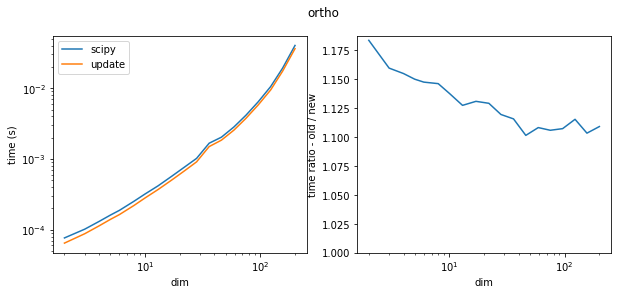

In [29]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
f.suptitle('ortho')

ax0.loglog(dims, ts_o[0].mean(axis=-1), label='scipy')
ax0.loglog(dims, ts_o[1].mean(axis=-1), label='update')
ax0.set_xlabel('dim')
ax0.set_ylabel('time (s)')
ax0.legend(loc='best')

ax1.semilogx(dims, ts_o[0].mean(axis=-1) / ts_o[1].mean(axis=-1))
ax1.set_xlabel('dim')
ax1.set_ylabel('time ratio - old / new')
ax1.set_ylim(1, None)
plt.savefig('ortho.png')